In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(gammapy)

loaded gammapy version: 0.1.dev19174+g56b5bdf 
<module 'gammapy' from '/home/wecapstor1/caph/mppi045h/gammapy/gammapy/__init__.py'>


In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [3]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')
sys.path.append('../')
from Dataset_Creation import sys_dataset
import Dataset_load 

## Read dataset

In [27]:
config = Dataset_load.load_config()
colors = config['colors']['one']

In [4]:
livetimes = np.logspace(0, 2,  7)
print(livetimes)

[  1.           2.15443469   4.64158883  10.          21.5443469
  46.41588834 100.        ]


In [5]:
%%time
scale  = 0.025 
scaled_amplitude = Parameter('amplitude', 
                             value = 4.11e-11 * scale)
datasets_asimov = []
for l in livetimes:
    dataset_asimov_2  = Dataset_load.create_asimov(model = 'pl', source = "PKSflare", 
                                                   livetime = f"{l}-hr",
                                            parameters = Parameters([scaled_amplitude]))
    datasets_asimov.append(dataset_asimov_2)

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-1.0-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-4.641588833612778-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-10.0-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-21.544346900318832-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-46.41588833612777-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-100.0-hr.fits.gz
CPU times: user 43.7 s, sys: 1.59 s, total: 45.3 s
Wall time: 45.3 s


In [6]:
dataset_asimov  = Dataset_load.create_asimov(model = 'pl', source = "PKSflare", 
                                            parameters = Parameters([scaled_amplitude]))

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-pl.fits.gz


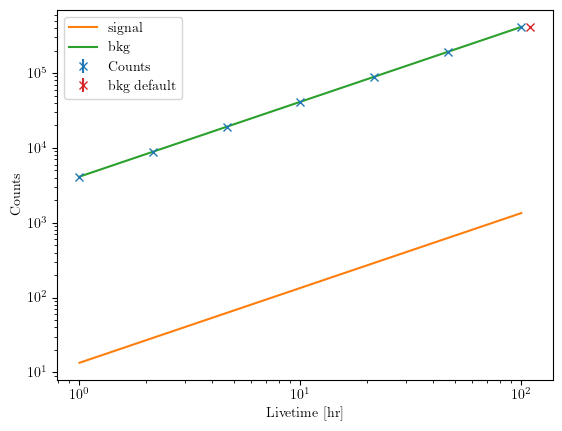

In [7]:
counts, signal, bkg = [] , [], []
for d in datasets_asimov:
    counts.append(d.counts.data.sum())
    signal.append(d.npred_signal().data.sum())
    bkg.append(d.npred_background().data.sum())
    
    
plt.errorbar(livetimes, counts, yerr = np.sqrt(counts), fmt= 'x', label = "Counts")
plt.plot(livetimes, signal, label = "signal")
plt.plot(livetimes, bkg, label = "bkg")
counts = dataset_asimov.counts.data.sum() 

plt.errorbar(110,counts, yerr = np.sqrt(counts) , fmt= 'x', label = "bkg default")


plt.loglog()
plt.xlabel("Livetime [hr]")
plt.ylabel("Counts")
plt.legend()

## Datasets

In [8]:
true_energy = datasets_asimov[0].exposure.geom.axes[0].center.value



shift_as = 0.1
tilt_as = 0.015
bias_as, resolution_as = 0.1,0.1
bkg_norm_as, bkg_tilt_as = 0.1, 0.02



In [9]:
datasets_N = []
datasets_N_H0 = []

for d in datasets_asimov:
    sys_d_cor = sys_dataset(dataset_asimov= d,
                        shift = 0., 
                        tilt = 0.,
                        bias = 0.,
                        resolution = 0.,
                        bkg_norm = 0., 
                        bkg_tilt = 0., 
                        rnd = False,
                        e_reco_creation=100)
    dataset_cor_N = sys_d_cor.create_dataset_N(100)
    dataset_cor_N.background_model.parameters['tilt_nuisance'].frozen = False
    dataset_cor_N.irf_model.parameters['tilt_nuisance'].frozen = False
    datasets_N.append(dataset_cor_N)
    dataset_cor_N = sys_d_cor.create_dataset_N(100)
    dataset_cor_N.background_model.parameters['tilt_nuisance'].frozen = False
    dataset_cor_N.irf_model.parameters['tilt_nuisance'].frozen = False
    datasets_N_H0.append(dataset_cor_N)
        

In [10]:
zero = 1e-24

## addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((6, 6))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/bkg_norm_as ** 2, 1/ bkg_tilt_as**2 ,1/bias_as**2, 1/resolution_as**2, 1/shift_as**2, 1/tilt_as**2, ])
for i in range(len(datasets_N)):
    datasets_N[i].penalising_invcovmatrix = penalising_invcovmatrix
for i in range(len(datasets_N_H0)):
    datasets_N_H0[i].penalising_invcovmatrix = penalising_invcovmatrix


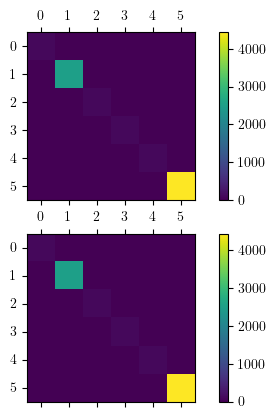

In [11]:
fig, ax = plt.subplots(2,1)
#ax = fig.add_subplot(111)
cax = ax[0].matshow(penalising_invcovmatrix)  # interpolation='nearest')
fig.colorbar(cax);
cax = ax[1].matshow(penalising_invcovmatrix)  # interpolation='nearest')
fig.colorbar(cax);

[]

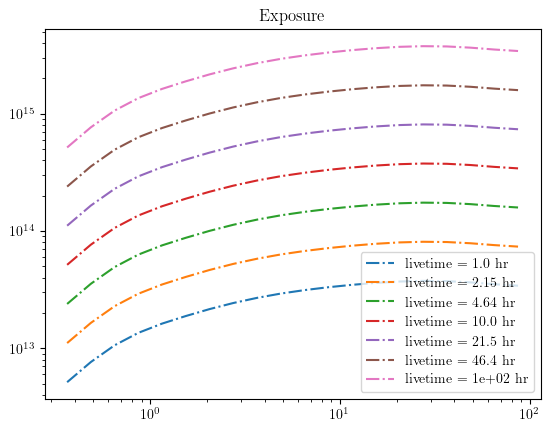

In [12]:
emask = dataset_cor_N.mask.data.sum(axis=2).sum(axis=1) >0 

e_bins = dataset_cor_N.geoms['geom'].axes[0].center.value[emask]

true_energy = dataset_cor_N.exposure.geom.axes[0].center.value[emask]
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)[emask]

for i, d in enumerate(datasets_N):
    plt.plot(e_bins,sum_e(d.exposure.data ), label = f'livetime = {livetimes[i]:.3} hr', linestyle='-.')

plt.title("Exposure")
plt.legend()
plt.loglog()

[]

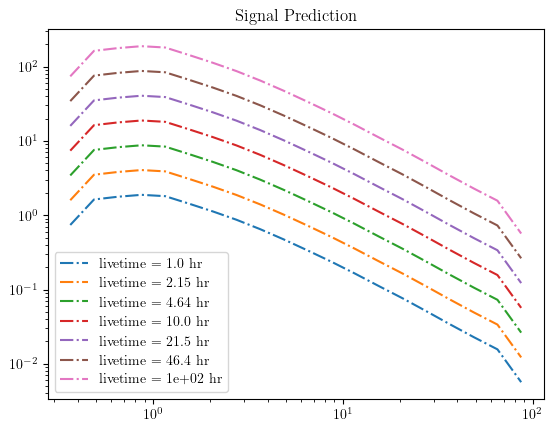

In [13]:
npred = []
for i, d in enumerate(datasets_N):
    plt.plot(e_bins,sum_e(d.npred_signal().data ), label = f'livetime = {livetimes[i]:.3} hr', linestyle='-.')
    npred.append(d.npred_signal().data.sum())
plt.title("Signal Prediction")
plt.legend()
plt.loglog()



[]

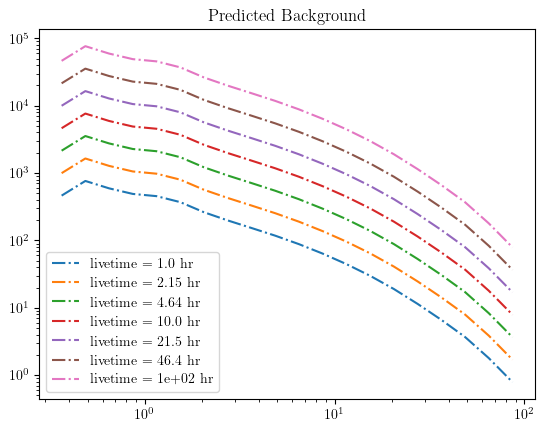

In [14]:
for i, d in enumerate(datasets_N):
    plt.plot(e_bins,sum_e(d.npred_background().data ), label = f'livetime = {livetimes[i]:.3} hr', linestyle='-.')

plt.title("Predicted Background")

plt.legend()
plt.loglog()

In [15]:
%%time
fitting = 0


if fitting:
    for i, d in enumerate(datasets_N):
        print(i)
        fit_cor = Fit(store_trace=True)
        result_cor = fit_cor.run(d)
        print(result_cor)
        d.models.covariance = fit_cor.covariance(d).matrix
        d.models.covariance.plot_correlation()
        print("saving")
        path = f'data/8_model_nui_livetime_{livetimes[i]}.yml'
        d.models.write(path,overwrite=True)
    
else:
    print("read")
    for i, d in enumerate(datasets_N):
        path = f'data/8_model_nui_livetime_{livetimes[i]}.yml'
        datasets_N[i] = Dataset_load.load_dataset_N(d, path,bkg_sys = True)        
        datasets_N[i].models.parameters['tilt_nuisance'].frozen = False 
    



read
CPU times: user 667 ms, sys: 182 ms, total: 848 ms
Wall time: 860 ms


In [16]:
print("read")
datasets = []
for i, d in enumerate(datasets_N):
    path = f'data/8_model_livetime_{livetimes[i]}.yml'
    da = Dataset_load.load_dataset(d, path)     
    datasets.append(da)

read


In [26]:
colors

UsageError: %colors: you must specify a color scheme. See '%colors?'


Text(0.5, 0, 'Signal Counts')

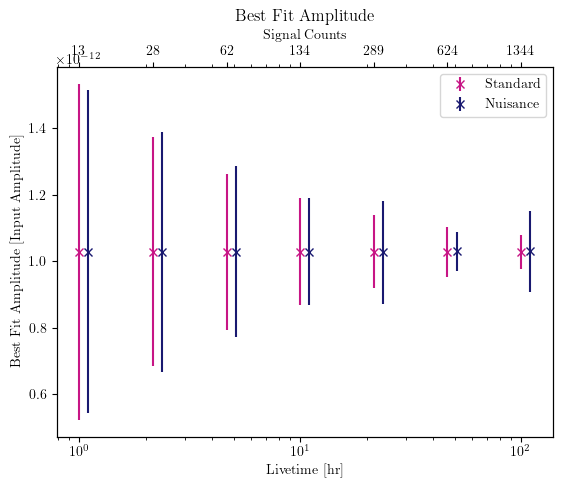

In [30]:
input_amplitude = scaled_amplitude.value  * 0.025
input_amplitude = 1
parname = 'amplitude'
for i, d in enumerate(datasets_N):
    par = datasets[i].models[0].parameters[parname]
    val, err = par.value, par.error
    plt.errorbar(livetimes[i], val/ input_amplitude, yerr = err/ input_amplitude,  fmt='x', 
                 color = colors[0])
    
    par = d.models[0].parameters[parname]
    val, err = par.value, par.error
    plt.errorbar( 1.1* livetimes[i] , val/ input_amplitude, yerr = err/ input_amplitude,  fmt='x', 
                 color = colors[1])

plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = colors[0], label = 'Standard')
plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = colors[1], label = 'Nuisance')
ax1 = plt.gca()
xlim = ax1.get_xlim()
#plt.hlines(1, xlim[0], xlim[1], color = 'grey')
plt.title("Best Fit Amplitude")
plt.legend()
plt.xscale('log')
plt.xlabel("Livetime [hr]")
plt.ylabel(f"Best Fit Amplitude [Input Amplitude]")

ax2 = ax1.twiny()
ax2.set_xscale("log")

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(livetimes)
clabels = [ f'{int(c)}' for c in npred]
ax2.set_xticklabels(clabels)
ax2.set_xlabel(r"Signal Counts")


Text(0, 0.5, 'Best Fit Index []')

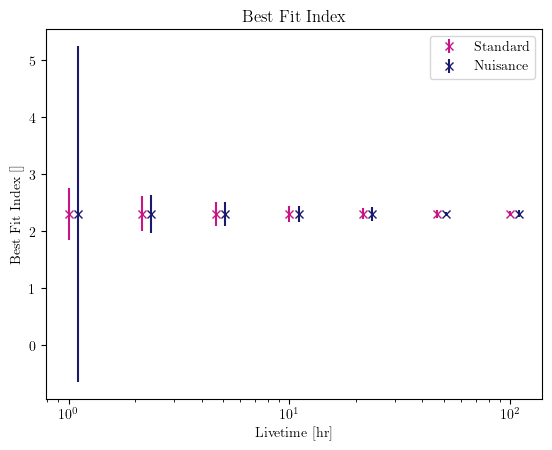

In [31]:
parname = 'index'
for i, d in enumerate(datasets_N):
    par = datasets[i].models[0].parameters[parname]
    val, err = par.value, par.error
    plt.errorbar(livetimes[i], val, yerr = err,  fmt='x', color = colors[0])
    
    par = d.models[0].parameters[parname]
    val, err = par.value, par.error
    plt.errorbar( 1.1* livetimes[i] , val, yerr = err,  fmt='x', color = colors[1])
    
plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = colors[0], label = 'Standard')
plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = colors[1], label = 'Nuisance')
    

plt.title("Best Fit Index")
plt.legend()
plt.xscale('log')
plt.xlabel("Livetime [hr]")
plt.ylabel(f"Best Fit Index [{par.unit}]")


## Significance

In [19]:
%%time
fitting = 0
if fitting:
    for i, d in enumerate(datasets_N_H0):
        print(i)
        datasets_N_H0[i].models.parameters['amplitude'].value = 1e-24
        datasets_N_H0[i].models.parameters['amplitude'].frozen  = True
        
        print("pre fit" , datasets_N_H0[i])
        fit_cor = Fit()
        result_cor = fit_cor.run(d)
        print("post" , datasets_N_H0[i])
        
        print(result_cor)
        
        print("saving")
        path = f'data/8_model_nui_H0_livetime_{livetimes[i]}.yml'
        d.models.write(path,overwrite=True)
else:
    print("read")
    for i, d in enumerate(datasets_N_H0):
        path = f'data/8_model_nui_H0_livetime_{livetimes[i]}.yml'
        datasets_N_H0[i]= Dataset_load.load_dataset_N(d, path, bkg_sys = True)
        datasets_N_H0[i].penalising_invcovmatrix = penalising_invcovmatrix



read


FileNotFoundError: [Errno 2] No such file or directory: 'data/8_model_nui_H0_livetime_100.0.yml'

In [20]:
datasets_H0 = []
print("read")
for i, d in enumerate(datasets_N):
    path = f'data/8_model_H0_livetime_{livetimes[i]}.yml'
    datasets_H0.append(Dataset_load.load_dataset(d, path))

read


In [21]:
sig , sig_N = [], []
for i, l in enumerate(livetimes):
    print()
    print(l)
    H0 = datasets_H0[i].stat_sum()
    H1 = datasets[i].stat_sum()
    print("HO", H0)
    print("H1", H1)
    
    sig.append(np.sqrt(np.abs(H0- H1)))
    print("sig", sig)
    
    H0 = datasets_N_H0[i].stat_sum()
    H1 = datasets_N[i].stat_sum()
    sig_N.append(np.sqrt(np.abs(H0- H1)))
    print("HO", H0)
    print("H1", H1)
    print("sig_N", sig_N)
    


1.0
HO 46694.38935688716
H1 46685.824518065565
sig [2.9265745884211247]
HO 46694.38384488303
H1 46685.82453308153
sig_N [2.925630154598307]

2.154434690031884
HO 86888.99787845903
H1 86870.54564348827
sig [2.9265745884211247, 4.2956064729871954]
HO 86888.98606215988
H1 86870.54565075661
sig_N [2.925630154598307, 4.2942300128504876]

4.641588833612778
HO 157657.18666622436
H1 157617.4323820405
sig [2.9265745884211247, 4.2956064729871954, 6.3050998551842135]
HO 157657.13660240232
H1 157617.432459661
sig_N [2.925630154598307, 4.2942300128504876, 6.301122339814232]

10.0
HO 276021.2218395339
H1 275935.57352913497
sig [2.9265745884211247, 4.2956064729871954, 6.3050998551842135, 9.254637237564516]
HO 276021.0591731285
H1 275935.573696525
sig_N [2.925630154598307, 4.2942300128504876, 6.301122339814232, 9.245835635760494]

21.544346900318832
HO 457559.55309004406
H1 457375.02952825965
sig [2.9265745884211247, 4.2956064729871954, 6.3050998551842135, 9.254637237564516, 13.583945000787345]
HO 45

Text(0.5, 0, 'Signal Counts')

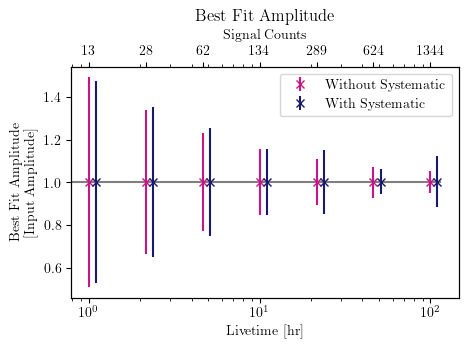

In [32]:
fig, (ax1) = plt.subplots(1,1, figsize = ((5,3)))

input_amplitude = scaled_amplitude.value # * 0.025
parname = 'amplitude'
for i, d in enumerate(datasets_N):
    par = datasets[i].models[0].parameters[parname]
    val, err = par.value, par.error
    ax1.errorbar(livetimes[i], val/ input_amplitude, yerr = err/ input_amplitude,  fmt='x', 
                 color = colors[0])
    
    par = d.models[0].parameters[parname]
    val, err = par.value, par.error
    ax1.errorbar( 1.1* livetimes[i] , val/ input_amplitude, yerr = err/ input_amplitude,  
                 fmt='x', color = colors[1])

ax1.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = colors[0], label = 'Without Systematic')
ax1.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = colors[1], label = 'With Systematic')
xlim = ax1.get_xlim()
ax1.hlines(1, xlim[0], xlim[1], color = 'grey')
ax1.set_title("Best Fit Amplitude")
ax1.legend()
ax1.set_xscale('log')
ax1.set_xlabel("Livetime [hr]")
ax1.set_ylabel(f"Best Fit Amplitude \n[Input Amplitude]")

ax1a = ax1.twiny()
ax1a.set_xscale("log")

ax1a.set_xlim(ax1.get_xlim())
ax1a.set_xticks(livetimes)
clabels = [ f'{int(c)}' for c in npred]
ax1a.set_xticklabels(clabels)
ax1a.set_xlabel(r"Signal Counts")



Parameter(name='amplitude', value=1.0275e-12, factor=1.0275e-12, scale=1.0, unit=Unit(dimensionless), min=nan, max=nan, frozen=False, id=0x7f801e5032e0, is_penalised=False)


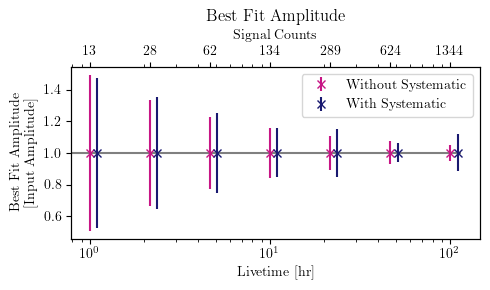

In [35]:
fig, (ax1) = plt.subplots(1,1, figsize = ((5,3)))

input_amplitude = scaled_amplitude.value # * 0.025
print(scaled_amplitude)
parname = 'amplitude'

for i, d in enumerate(datasets_N):
    par = datasets[i].models[0].parameters[parname]
    val, err = par.value, par.error
    ax1.errorbar(livetimes[i], val/ input_amplitude, yerr = err/ input_amplitude,  fmt='x', 
                 color = colors[0])
    
    par = d.models[0].parameters[parname]
    val, err = par.value, par.error
    ax1.errorbar( 1.1* livetimes[i] , val/ input_amplitude, yerr = err/ input_amplitude,  fmt='x',
                 color = colors[1])

ax1.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color =colors[0], label = 'Without Systematic')
ax1.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = colors[1], label = 'With Systematic')
xlim = ax1.get_xlim()
ax1.hlines(1, xlim[0], xlim[1], color = 'grey')
ax1.set_title("Best Fit Amplitude")
ax1.legend()
ax1.set_xscale('log')
ax1.set_xlabel("Livetime [hr]")
ax1.set_ylabel(f"Best Fit Amplitude \n[Input Amplitude]")



ax1a = ax1.twiny()
ax1a.set_xscale("log")

ax1a.set_xlim(ax1.get_xlim())
ax1a.set_xticks(livetimes)
clabels = [ f'{int(c)}' for c in npred]
ax1a.set_xticklabels(clabels)
ax1a.set_xlabel(r"Signal Counts")
plt.tight_layout()
fig.savefig("plots/8_best_fit_vs_livetime.png")
fig.savefig("plots/8_best_fit_vs_livetime.pdf")


## End Plot

[9.44433823e-04 1.37646014e-03 3.97751537e-03 8.80160180e-03
 2.07021782e-02 4.83852925e-02 2.95733968e+01]


Text(0, 0.5, 'Signifiance \n[$\\sigma$]')

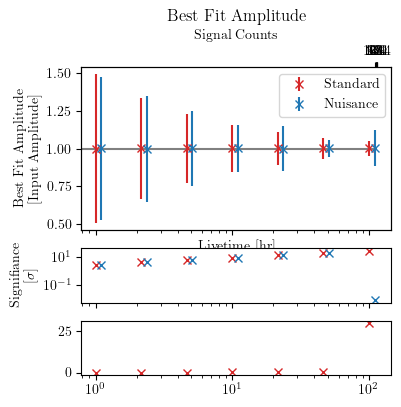

In [24]:
fig, (ax1, ax2,ax3) = plt.subplots(3,1, gridspec_kw={'height_ratios': [3, 1,1]},
                         sharex = True, figsize = ((4,4)))

input_amplitude = scaled_amplitude.value # * 0.025
parname = 'amplitude'
for i, d in enumerate(datasets_N):
    par = datasets[i].models[0].parameters[parname]
    val, err = par.value, par.error
    ax1.errorbar(livetimes[i], val/ input_amplitude, yerr = err/ input_amplitude,  fmt='x', color = 'tab:red')
    
    par = d.models[0].parameters[parname]
    val, err = par.value, par.error
    ax1.errorbar( 1.1* livetimes[i] , val/ input_amplitude, yerr = err/ input_amplitude,  fmt='x', color = 'tab:blue')

ax1.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:red', label = 'Standard')
ax1.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:blue', label = 'Nuisance')
xlim = ax1.get_xlim()
ax1.hlines(1, xlim[0], xlim[1], color = 'grey')
ax1.set_title("Best Fit Amplitude")
ax1.legend()
ax1.set_xscale('log')
ax1.set_xlabel("Livetime [hr]")
ax1.set_ylabel(f"Best Fit Amplitude \n[Input Amplitude]")

ax1a = ax1.twiny()
ax1a.set_xscale("log")

ax1a.set_xlim(ax1.get_xlim())
ax1a.set_xticks(livetimes)
clabels = [ f'{int(c)}' for c in npred]
ax1a.set_xticklabels(clabels)
ax1a.set_xlabel(r"Signal Counts")


ax2.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:red', label = 'Standard')
ax2.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:blue', label = 'Nuisance')

ax2.plot(livetimes, sig, linestyle = '', marker = 'x', color = 'tab:red')
ax2.plot(livetimes*1.1, sig_N, linestyle = '', marker = 'x', color = 'tab:blue')
ax2.loglog()

print(np.array(sig) - np.array(sig_N))
ax3.plot(livetimes, (np.array(sig) - np.array(sig_N)), linestyle = '', marker = 'x', color = 'tab:red')
#ax3.loglog()
ax3.set_xscale("log")
ax2.set_ylabel("Signifiance \n[$\sigma$]")               

## Correlation Matrices

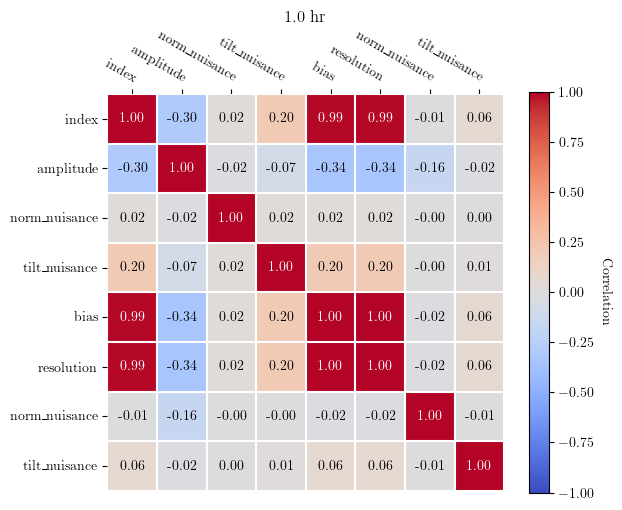

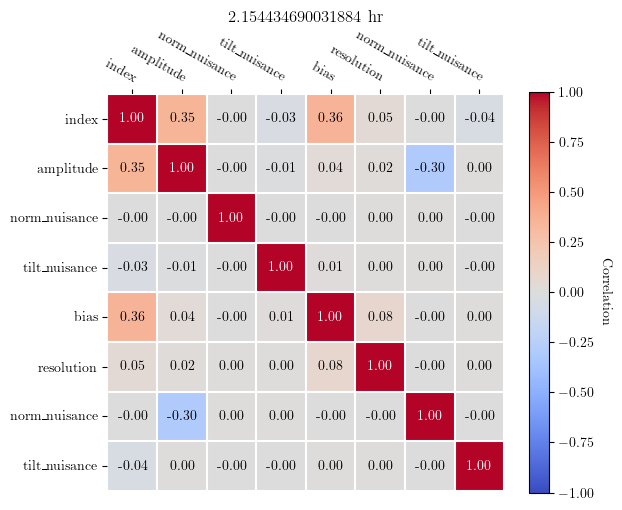

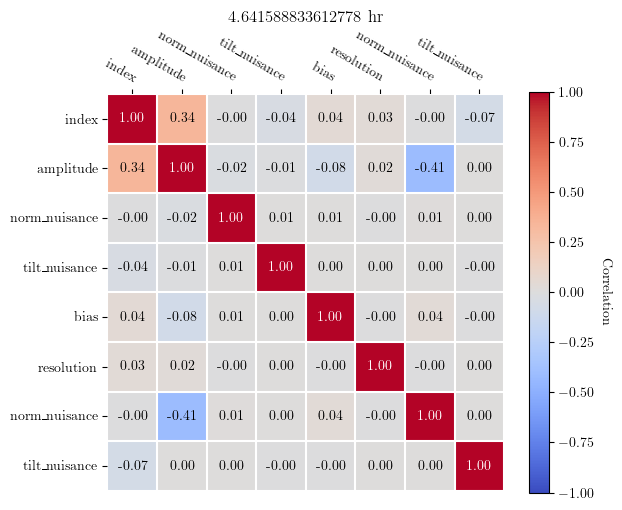

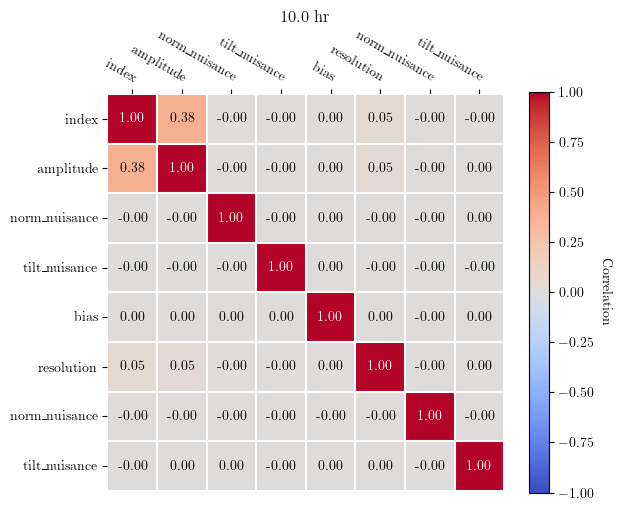

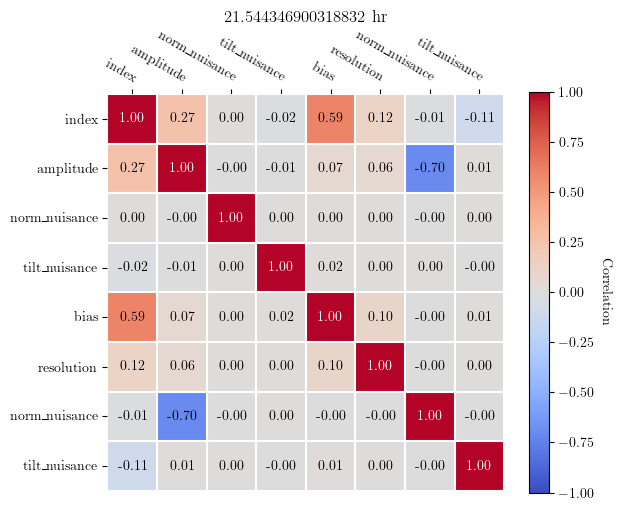

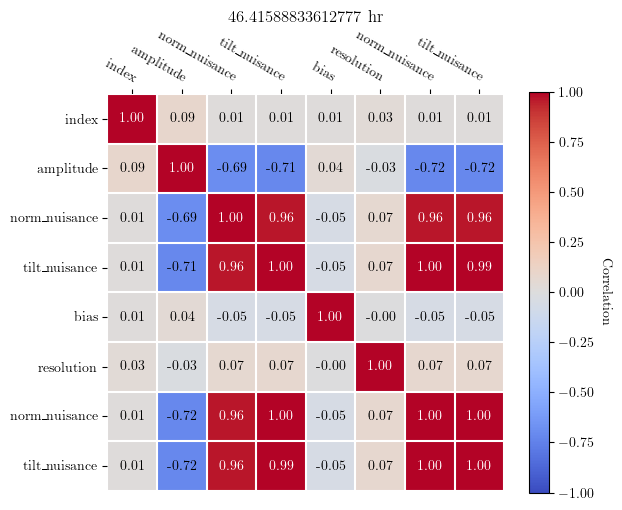

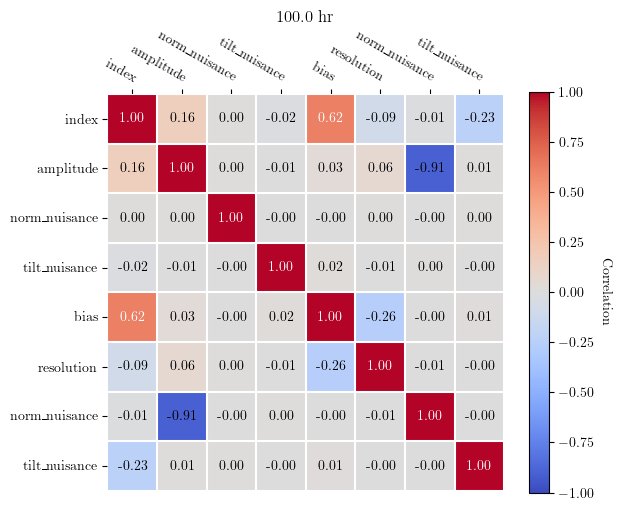

In [25]:
par_names = ['index', 'amplitude', 'lambda_', 'bias', 'resolution', 'norm_nuisance' , 
            'tilt_nuisance']
names =  ['index', 'amplitude',  
        'bkg norm', 'bkg tilt',
          'bias', 'resolution',
          'eff. area norm' , 
            'eff. area tilt']
for i in range(len(livetimes)):

    datasets_N[i].models.read_covariance("data", f"8_model_nui_livetime_{livetimes[i]}_covariance.dat", format="ascii.fixed_width")
    parameters = Parameters([_ for _ in datasets_N[i].models.parameters if _.name in par_names])
    cov_par = datasets_N[i].models.covariance.get_subcovariance(parameters)
    ax = cov_par.plot_correlation()
    ax.set_title(str(livetimes[i]) + " hr")